# 動学BLP（J＝１、R＝１）NFXP

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
from itertools import product
from scipy.optimize import minimize, Bounds
import time
import scipy.special as sp
import sys
import warnings
warnings.filterwarnings('error')

## モデル

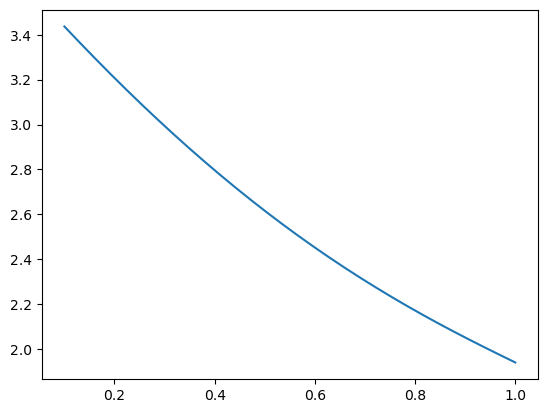

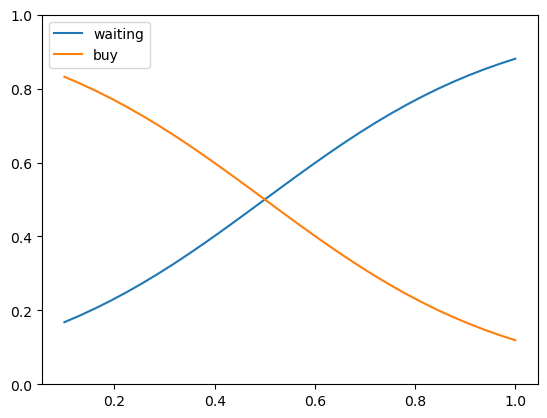

In [24]:
class durable_goods_adoption_model():
    
    def __init__(self,
                 ngrid=30,
                 n_min=0.1,
                 n_max=1,
                 nquad=8,
                 rho=[0.05,0.95],
                 cov=[0.002, 0.001, 0.001, 0.003],
                 beta=2,
                 alpha=-4,
                 delta=0.99):
        
        self.ngrid = ngrid
        self.grid = np.linspace(n_min, n_max, ngrid)
        self.nquad = nquad
        self.rho = np.array(rho)
        self.cov = np.array(cov).reshape(2,2)
        self.beta = beta
        self.alpha = alpha
        self.delta = delta
        self.quadrature_setup()
        
        
    def quadrature_setup(self):
        
        node, weight = np.polynomial.hermite.hermgauss(self.nquad)
        chol_matrix =  np.linalg.cholesky(self.cov)
        self.node_phi, self.node_xi = np.sqrt(2)*chol_matrix@np.vstack((node,node))
        # node_phi , node_xi is array([node_1,...,node_nquad])
        node_phi_xi = np.array(list(product(self.node_phi,self.node_xi))).T
        # 2 by nquad**2  array. All possible combination of node_phi and node_xi 
        weight_phi_xi = np.array(list(product(weight/np.sqrt(np.pi), weight/np.sqrt(np.pi)))).T
        # 2 by nquad**2 array. All possible combination of different weights 
        
        self.node_phi,self.node_xi = node_phi_xi[0],node_phi_xi[1]
        # each node is nquad**2 by 1 array
        self.weight_phi,self.weight_xi = weight_phi_xi[0],weight_phi_xi[1]
        # each weight is nquad**2 by 1 array
        
        
    def interp_func(self,x,f):
        """
        x is state gird.
        f is f(x) to be interpolated.

        """
        return interpolate.interp1d(x,f,kind='slinear',fill_value="extrapolate")

    
    def next_period_price(self,current_price):
        current_price = current_price[:,np.newaxis]
        next_price = self.rho[0] + self.rho[1]*current_price + self.node_phi
        # ngrid by nquad**2 array

        return next_price
    
    
    def bellman(self,V0):
        """
        V0 is assumed to be 1 by ngrid array
        """
        next_price = self.next_period_price(current_price = self.grid)
        # compute V0
        inter = self.interp_func(self.grid,V0)
        V0 = inter(next_price)
        # ngrid by nquad**2 array

        # compute EV_purchase
        V_purchase = self.beta+self.alpha*next_price+self.node_xi
        
        M = np.maximum(V0,V_purchase)   
        try:
            new_V0 = self.delta*(M+np.log(np.exp(V0-M)+np.exp(V_purchase-M)))@(self.weight_phi*self.weight_xi).T
        except RuntimeWarning:
             print("Overflow error occurred! in new_V0")
        
        return new_V0
    
    
    def solve_vfi(self,maxiter=1000000,tol=1e-8):
        '''Solves the model using value function iterations (successive approximations of Bellman operator)
           Callback function is invoked at each iteration with keyword arguments.
        '''
        V0 = np.zeros(self.ngrid) # initial guess
        for iter in range(maxiter):
            V1= self.bellman(V0)
            err = np.amax(np.abs(V1-V0))
            if err < tol:
                break  # converged!
            V0 = V1  # prepare for the next iteration
            iter += 1
        else:  # when iter went up to maxiter
            print(f"V1:{V1}")
            print(f"err:{err}")
            raise RuntimeError('No convergence: maximum number of iterations achieved!')
        return V1


    
model = durable_goods_adoption_model()
v0 = model.solve_vfi()
plt.plot(model.grid,v0)
plt.show()
p0 = 1/(np.exp(v0-v0)+np.exp(model.beta+model.alpha*model.grid))
p1 = 1-p0
plt.plot(model.grid,p0,label="waiting")
plt.plot(model.grid,p1,label="buy")
plt.ylim(0,1)
plt.legend()
plt.show()

## 比較静学

#### 色が濃いほどαは大きい

i:0,alpha:0.0
alpha:-4.0,beta:2
i:1,alpha:0.05
alpha:-3.95,beta:2
i:2,alpha:0.1
alpha:-3.9000000000000004,beta:2
i:3,alpha:0.15
alpha:-3.8500000000000005,beta:2
i:4,alpha:0.2
alpha:-3.8000000000000007,beta:2
i:5,alpha:0.25
alpha:-3.750000000000001,beta:2
i:6,alpha:0.3
alpha:-3.700000000000001,beta:2
i:7,alpha:0.35
alpha:-3.6500000000000012,beta:2
i:8,alpha:0.4
alpha:-3.6000000000000014,beta:2
i:9,alpha:0.45
alpha:-3.5500000000000016,beta:2
i:10,alpha:0.5
alpha:-3.5000000000000018,beta:2
i:11,alpha:0.55
alpha:-3.450000000000002,beta:2
i:12,alpha:0.6
alpha:-3.400000000000002,beta:2
i:13,alpha:0.65
alpha:-3.3500000000000023,beta:2
i:14,alpha:0.7
alpha:-3.3000000000000025,beta:2
i:15,alpha:0.75
alpha:-3.2500000000000027,beta:2
i:16,alpha:0.8
alpha:-3.200000000000003,beta:2
i:17,alpha:0.85
alpha:-3.150000000000003,beta:2
i:18,alpha:0.9
alpha:-3.100000000000003,beta:2
i:19,alpha:0.95
alpha:-3.0500000000000034,beta:2


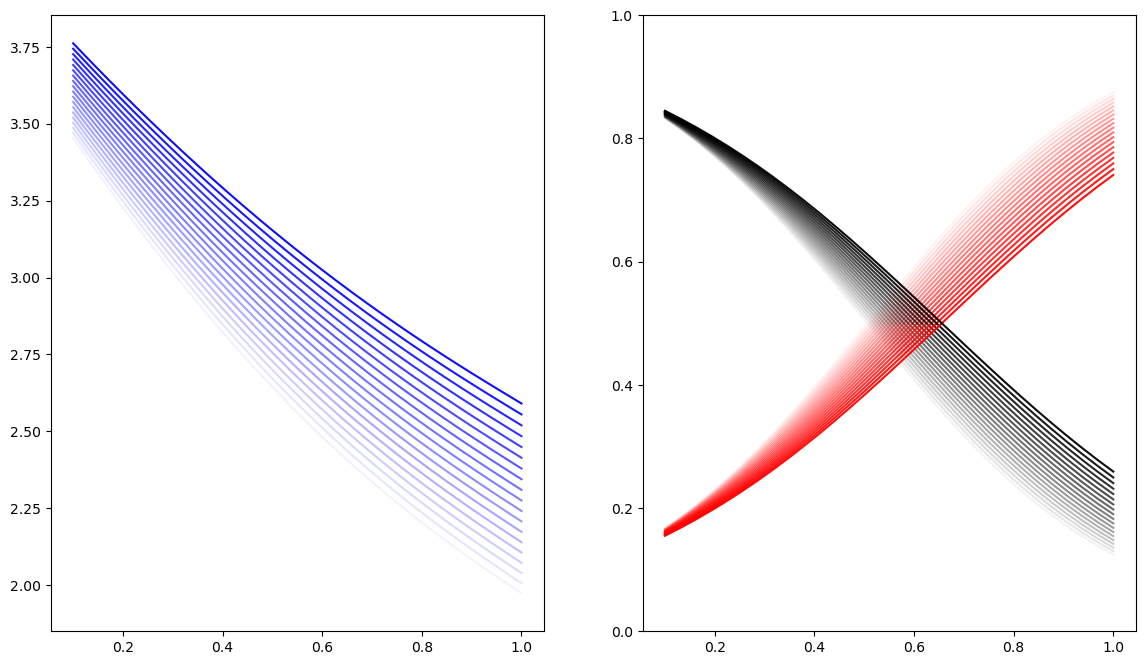

In [25]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
i = 0
arange = np.arange(-4,-3,0.05)
for alpha in arange:
    for beta in [2]:
        print(f"i:{i},alpha:{i/len(arange)}")
        print(f"alpha:{alpha},beta:{beta}")
        model =  durable_goods_adoption_model(n_max = 1,alpha = alpha,beta = beta)
        v0 = model.solve_vfi()
        ax1.plot(model.grid,v0,color="blue",alpha = i/len(arange))
        p0 = 1/(np.exp(v0-v0)+np.exp(model.beta+model.alpha*model.grid))
        p1 = 1-p0
        ax2.plot(model.grid,p0,label="waiting",color="red",alpha = i/len(arange))
        ax2.plot(model.grid,p1,label="buy",color="black",alpha = i/len(arange))
        i+=1
plt.ylim(0,1)
plt.show()

#### 色が濃いほどβは大きい

i:0,alpha:0.0
alpha:-4,beta:2.0
i:1,alpha:0.1
alpha:-4,beta:2.1
i:2,alpha:0.2
alpha:-4,beta:2.2
i:3,alpha:0.3
alpha:-4,beta:2.3000000000000003
i:4,alpha:0.4
alpha:-4,beta:2.4000000000000004
i:5,alpha:0.5
alpha:-4,beta:2.5000000000000004
i:6,alpha:0.6
alpha:-4,beta:2.6000000000000005
i:7,alpha:0.7
alpha:-4,beta:2.7000000000000006
i:8,alpha:0.8
alpha:-4,beta:2.8000000000000007
i:9,alpha:0.9
alpha:-4,beta:2.900000000000001


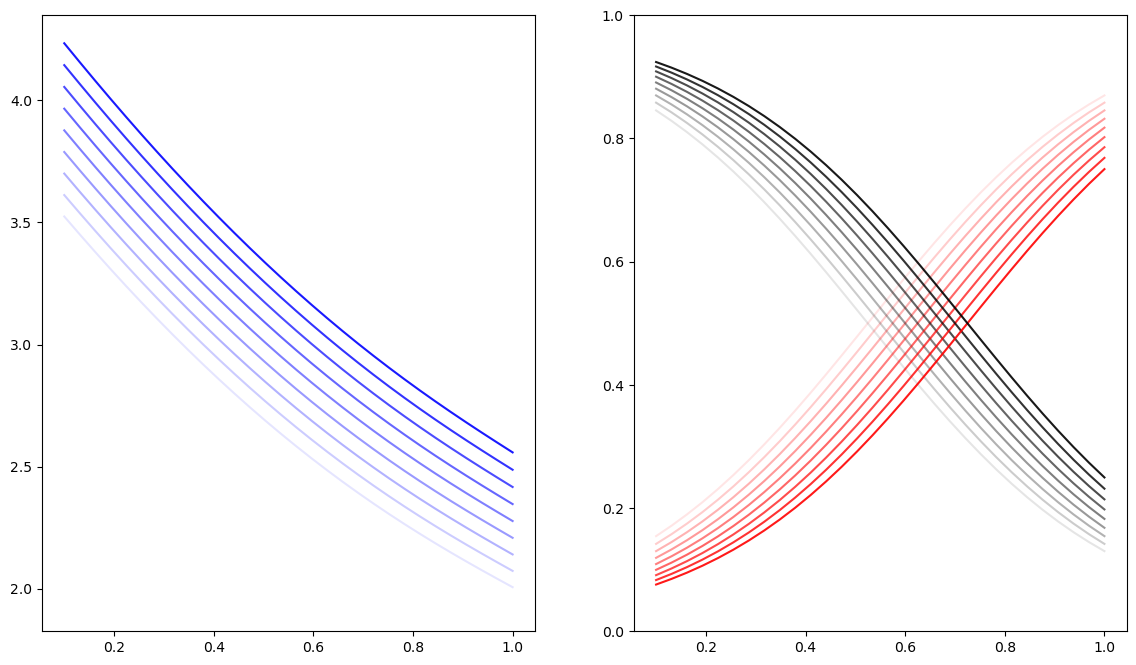

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
i = 0
alpha = -4
arange = np.arange(2,3,0.1)
for beta in arange:   
    print(f"i:{i},alpha:{i/len(arange)}")
    print(f"alpha:{alpha},beta:{beta}")
    model =  durable_goods_adoption_model(n_max = 1,alpha = alpha,beta = beta)
    v0 = model.solve_vfi()
    ax1.plot(model.grid,v0,color="blue",alpha = i/len(arange))
    p0 = 1/(np.exp(v0-v0)+np.exp(model.beta+model.alpha*model.grid))
    p1 = 1-p0
    ax2.plot(model.grid,p0,label="waiting",color="red",alpha = i/len(arange))
    ax2.plot(model.grid,p1,label="buy",color="black",alpha = i/len(arange))
    i+=1
plt.ylim(0,1)
plt.show()

## データシミュレーション

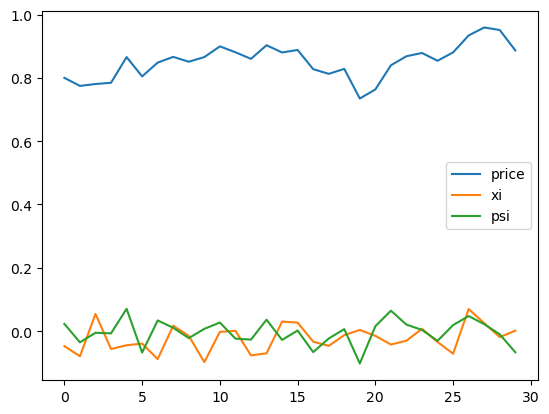

In [27]:
def simulate_price_process(T = 30,
                           price_0 = 0.8,
                           model = model,
                           seed= 1234):
    """
    Return price process
    First column is price process for product 1 and second for product 2.
    Number of row corresponds to time period
    """
    np.random.seed(seed)
    mean = np.array([0,0])
    
    shocks = np.random.multivariate_normal(mean,model.cov,size=T)
    psi,xi  = shocks[:,0],shocks[:,1]
    
    price = np.zeros(T)
    price[0] = np.array(price_0)
    for t in range(1,T):
        price[t] = model.rho[0] + model.rho[1]*price[t-1] + psi[t]

    return price,xi,psi
model = durable_goods_adoption_model()
price_test,xi_test,psi_test = simulate_price_process(T=30,model = model,seed = 1234)
plt.plot(price_test,label = "price")
plt.plot(xi_test,label = "xi")
plt.plot(psi_test,label = "psi")
plt.legend()
plt.show()

In [28]:
model = durable_goods_adoption_model()

def simulate_share(T=30,
                   M=50,
                   price_0=0.8,
                   lambda1=1,
                   model=model,
                   price_model = model,
                   seed = 1234):
    
    beta,alpha = model.beta,model.alpha
     
    price,xi,_ = simulate_price_process(T,price_0=price_0,model = price_model,seed = seed)
    
    V0 = model.solve_vfi()
    
    inter = model.interp_func(model.grid,V0)
    V0 = inter(price)
    
    
    share = np.empty(T)
    outside_share = np.empty(T)
    sales = np.empty(T)
    outside_sales = np.empty(T)
    for t in range(T):     
        try:
            outside_share_t = (np.exp(V0[t]-V0[t])/(np.exp(V0[t]-V0[t])+np.exp(beta+alpha*price[t]+xi[t]-V0[t])))
        except RuntimeWarning:
            print("Overflow error occurred in outside_share")
            print(f"V_wait:{V0[t]}")
            print(f"V_purchase:{beta+alpha*price[t]+xi[t]-V0[t]}")
        share_t = 1-outside_share_t 
        sales_t = share_t*M
        outside_sales_t = M-sales_t
        M = outside_sales_t
        
        share[t] = share_t
        outside_share[t] = outside_share_t
        sales[t] = sales_t
        outside_sales[t] = outside_sales_t
        
    data = pd.DataFrame(np.hstack((sales[:,np.newaxis],outside_sales[:,np.newaxis],
                                   share[:,np.newaxis],outside_share[:,np.newaxis],
                                   price[:,np.newaxis])),
                    columns=["sales","outside_sales",
                             "share","outside_share",
                             "price"])   

    return data

data = simulate_share(T=120,M=1000,price_0=1,lambda1=1,model=model,price_model = model)
data

,sales,outside_sales,share,outside_share,price
0,18.202064,981.797936,0.018202,0.981798,1.000000
1,19.159108,962.638828,0.019514,0.980486,0.964581
2,21.623984,941.014844,0.022463,0.977537,0.961084
3,19.245725,921.769119,0.020452,0.979548,0.955976
4,15.503171,906.265947,0.016819,0.983181,1.028601
...,...,...,...,...,...
115,2.576824,85.329299,0.029313,0.970687,0.846203
116,2.252616,83.076683,0.026399,0.973601,0.882276
117,2.126437,80.950246,0.025596,0.974404,0.919728
118,2.622203,78.328043,0.032393,0.967607,0.817966


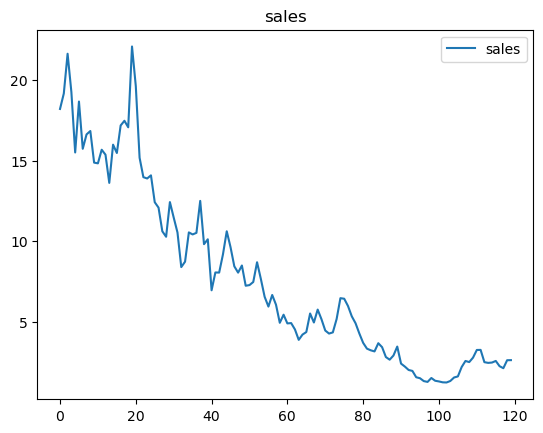

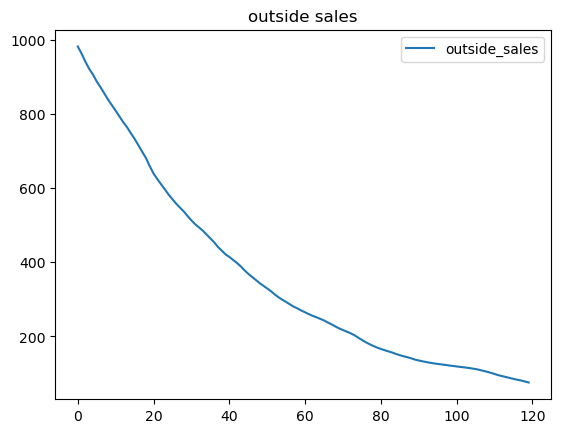

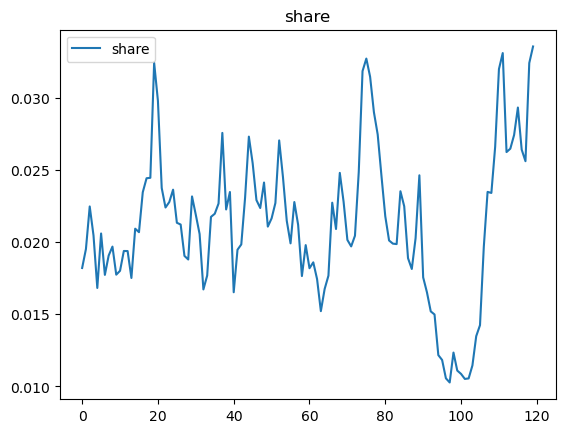

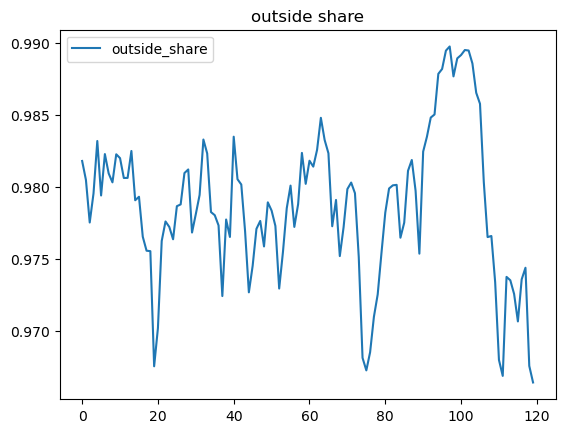

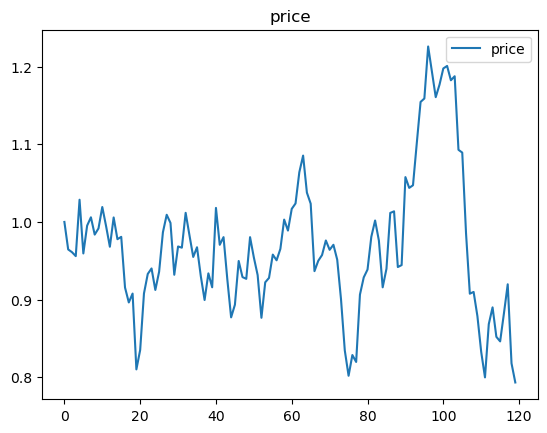

In [29]:
plt.plot(data["sales"],label="sales")
plt.title("sales")
plt.legend()
plt.show()

plt.plot(data["outside_sales"],label="outside_sales")
plt.title("outside sales")
plt.legend()
plt.show()

plt.plot(data["share"],label="share")
plt.title("share")
plt.legend()
plt.show()

plt.plot(data["outside_share"],label="outside_share")
plt.title("outside share")
plt.legend()
plt.show()

plt.plot(data["price"],label="price")
plt.title("price")
plt.legend()
plt.show()

## シェア計算（内ループ）

In [36]:
def calculate_share(lambda_type1,theta_type1,rho,cov,xi,data):
    lambda_type1_0 = lambda_type1
    
    M_0 = data.sales[0]+data.outside_sales[0]
    
    beta_type1,alpha_type1 = theta_type1[0],theta_type1[1]
       
    model_type1 = durable_goods_adoption_model(rho=rho,cov=cov,beta=beta_type1,alpha=alpha_type1)
    v0_type1 = model_type1.solve_vfi()
    inter_type1 = model_type1.interp_func(model_type1.grid,v0_type1)
    v0_type1 = inter_type1(data.price)
        
    try:
        share_decision0_type1 = (np.exp(v0_type1-v0_type1)/
           (np.exp(v0_type1-v0_type1)+
            np.exp(beta_type1+alpha_type1*data.price+xi-v0_type1)))
    except RuntimeWarning:
        print("Overflow error occurred in share_decision0_type1")
        print(f"v0:{v0_type1}")
        print(f"v1:{beta_type1+alpha_type1*data.price+xi-v0_type1}")
    
    
    share_decision1_type1 = 1-share_decision0_type1 
    
    M0_type1 = M_0*lambda_type1_0
    M_type1_t = np.concatenate([np.array([M0_type1]), (M0_type1*np.cumprod(share_decision0_type1))])[:-1]
    
    M_type1_t = M_type1_t[M_type1_t!=0]
    lambda_type1_t = M_type1_t/(M_type1_t)
    
    period_length = len(M_type1_t)
    share_decision0_type1 = share_decision0_type1[:period_length]
    share_decision1_type1 = share_decision1_type1[:period_length]
                             
    # share by type in proportion to total market size
    share_decision0_type1 = lambda_type1_t*share_decision0_type1
    share_decision1_type1 = lambda_type1_t*share_decision1_type1
    
    share_type1 = share_decision1_type1 + share_decision0_type1
    share = share_decision1_type1
    
    sales = share*(M_type1_t)
    sales_decision0 = share_decision0_type1*(M_type1_t)
    sales_decision1 = share_decision1_type1*(M_type1_t)
    sales_decision0_type1 = share_decision0_type1*(M_type1_t)
    sales_decision1_type1 = share_decision1_type1*(M_type1_t)
    sales_type1 = sales_decision1_type1
    
        
    predicted_share_data = pd.DataFrame(np.vstack((sales,sales_type1,
                                                   
                                                   sales_decision1_type1,sales_decision0_type1,                                             
                                                   share,
                                                  
                                                   share_type1,
                                                   share_decision1_type1,share_decision0_type1,                                             
                                                   lambda_type1_t,M_type1_t)).T,
                                        columns = ['sales',"sales_type1",
                                                  
                                                   'sales_decision1_type1','sales_decision0_type1',                                     
                                                   "share",
                                                 
                                                   'share_type1',
                                                   'share_decision1_type1','share_decision0_type1',                                     
                                                  'lambda1','market_size1'])
      
    return predicted_share_data

prediction =  calculate_share(lambda_type1=1,
                theta_type1=[model.beta,model.alpha],       
                rho=model.rho,cov=model.cov,                    
                xi=simulate_price_process(T=len(data),model=model)[1],
                data = data)
prediction

,sales,sales_type1,sales_decision1_type1,sales_decision0_type1,share,share_type1,share_decision1_type1,share_decision0_type1,lambda1,market_size1
0,18.202064,18.202064,18.202064,981.797936,0.018202,1.0,0.018202,0.981798,1.0,1000.000000
1,19.159108,19.159108,19.159108,962.638828,0.019514,1.0,0.019514,0.980486,1.0,981.797936
2,21.623984,21.623984,21.623984,941.014844,0.022463,1.0,0.022463,0.977537,1.0,962.638828
3,19.245725,19.245725,19.245725,921.769119,0.020452,1.0,0.020452,0.979548,1.0,941.014844
4,15.503171,15.503171,15.503171,906.265947,0.016819,1.0,0.016819,0.983181,1.0,921.769119
...,...,...,...,...,...,...,...,...,...,...
115,2.576824,2.576824,2.576824,85.329299,0.029313,1.0,0.029313,0.970687,1.0,87.906123
116,2.252616,2.252616,2.252616,83.076683,0.026399,1.0,0.026399,0.973601,1.0,85.329299
117,2.126437,2.126437,2.126437,80.950246,0.025596,1.0,0.025596,0.974404,1.0,83.076683
118,2.622203,2.622203,2.622203,78.328043,0.032393,1.0,0.032393,0.967607,1.0,80.950246


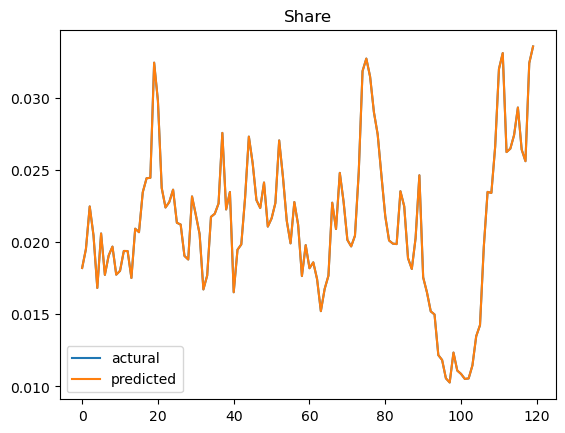

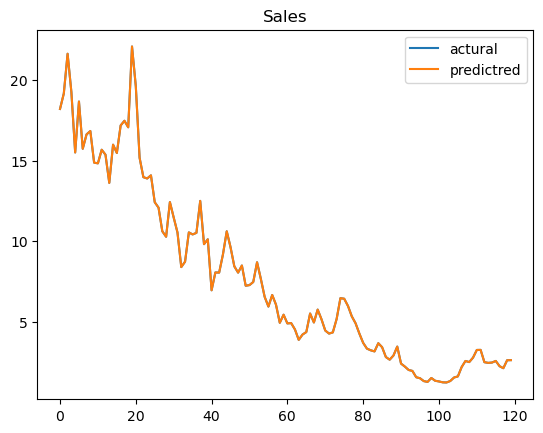

In [37]:
plt.plot(data.share,label="actural")
plt.plot(prediction.share,label="predicted")
plt.title("Share")
plt.legend()
plt.show()

plt.plot(data.sales,label="actural")
plt.plot(prediction.sales,label="predictred")
plt.title("Sales")
plt.legend()
plt.show()


## 縮小写像（中ループ）

In [38]:
def contraction_mapping(lambda_type1,theta_type1,
                        rho,cov,xi_guess,data,maxiter=1000000,tol=1e-8 ):
    xi0 = xi_guess
    for iter in range(maxiter):
        
        prediction =  calculate_share(lambda_type1=lambda_type1,
                                    theta_type1=theta_type1,                                
                                    rho=rho,cov=cov,
                                    xi=xi0,data = data)
        period_length = len(prediction)
        xi1 = xi0[:period_length] + np.log(data.share[:period_length]+1e-10)-np.log(prediction.share+1e-10)
        err = np.amax(np.abs(xi1-xi0[:period_length]))
        
        if err < tol:
            break  # converged!
        
        xi0 = xi1
        # prepare for the next iteration
        iter += 1
        
    else:  # when iter went up to maxiter
        print(f"xi0:{xi0}")
        print(f"err:{err}")
        raise RuntimeError('No convergence: maximum number of iterations achieved!')
    
    return xi1,prediction
start_time = time.time()
xi,share_hat = contraction_mapping(lambda_type1=1,
                         theta_type1=[model.beta,model.alpha],                     
                         rho=model.rho,cov=model.cov,
                         xi_guess = np.zeros(len(data)),
                         data = data)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")
xi

Time taken: 0.9612712860107422 seconds


0     -0.047398
1     -0.079417
2      0.054209
3     -0.056423
4     -0.044634
         ...   
115   -0.000357
116   -0.006433
117    0.068714
118    0.024285
119   -0.007367
Name: share, Length: 120, dtype: float64

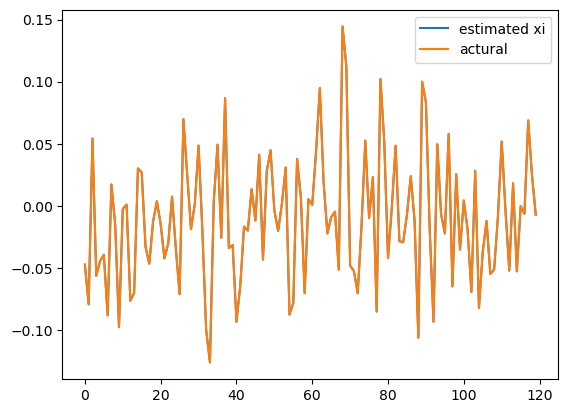

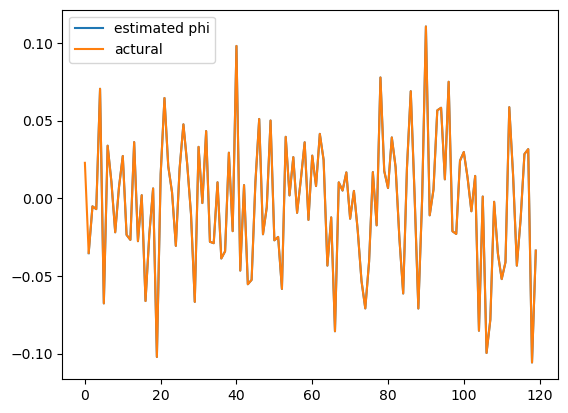

In [39]:
plt.plot(xi,label="estimated xi")
plt.plot(simulate_price_process(T=len(data))[1],label="actural")
plt.legend()
plt.show()
phi = data.price[1:]-(model.rho[0]+model.rho[1]*data.price.shift(1)[1:])
plt.plot(phi,label="estimated phi")
plt.plot(simulate_price_process(T=len(data))[2],label="actural")
plt.legend()
plt.show()

## 推定

In [40]:
def log_likelihood(theta,data):
    lambda_type1 = 1
    theta_type1 = theta[0:2]
    rho = np.array(theta[2:4])
    L = np.array([[theta[4],0],[theta[5],theta[6]]])
    covariance_matrix = np.dot(L, L.T)
    covariance_matrix += np.eye(covariance_matrix.shape[0]) * 1e-10
    
    xi,prediction = contraction_mapping(lambda_type1=lambda_type1,
                                       theta_type1=theta_type1,                                   
                                       rho=rho,cov=covariance_matrix,
                                       xi_guess = np.zeros(len(data)),
                                       data = data)
    period_length = len(prediction)
    psi = data.price[1:]-(rho[0]+rho[1]*data.price.shift(1)[1:])
    
    u = np.array([psi[:period_length],xi[1:]])
    
    
    log_lik = 0 # log likelihood
    
    for t in range(len(data[:period_length])-1):# compute log likelihood for each period of time
        Jaccobian =  np.abs(-(-1/(prediction.share_decision1_type1[t]*(1-prediction.share_decision1_type1[t]))))

        
        try:
            log_lik += np.log((1/(2*np.pi*np.sqrt(np.linalg.det(covariance_matrix)))
                       *np.exp(-1/2*u[:,t].T@np.linalg.inv(covariance_matrix)@u[:,t])
                       *Jaccobian)+1e-100)
        except RuntimeWarning:
            print("Overflow error occurred in log_lik")


        
    return -log_lik

log_likelihood(theta=[1,1,1,0.1,1,0.5,0.5,1],data=data)

-289.4012603700052

## 最適化（外ループ）

In [41]:
%%time

theta_initial = np.ones(7)

bounds = Bounds([ 0, -10, 0, 0, 0, 0, 0], 
                [10,  0,  10, 1, 1, 1,1])

# make covariance satisfy positive definite
def constraint(theta):
    L = np.array([[theta[4], 0], [theta[5], theta[6]]])
    covariance_matrix = np.dot(L, L.T)
    return np.linalg.eigvals(covariance_matrix)

constraints = {'type': 'ineq', 'fun': constraint}

result = minimize(log_likelihood, theta_initial, args=(data,), method='SLSQP',bounds=bounds,constraints=constraints)

# 最適なパラメータ
theta_optimal = result.x

CPU times: total: 8min 45s
Wall time: 11min 47s


In [50]:
print(f"beta:{theta_optimal[0]},alpha:{theta_optimal[1]},rho:{theta_optimal[2:4]}")

beta:1.7616917512095591,alpha:-3.5249483291240633,rho:[0.09627128 0.89907014]


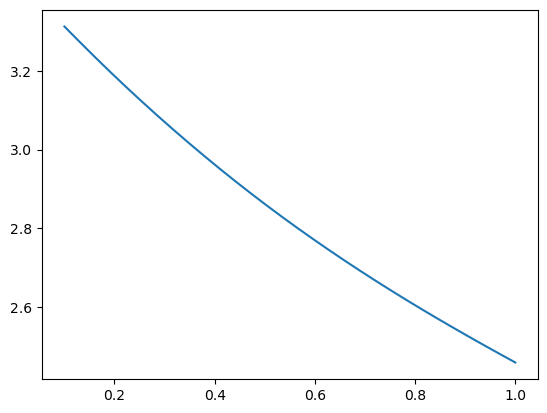

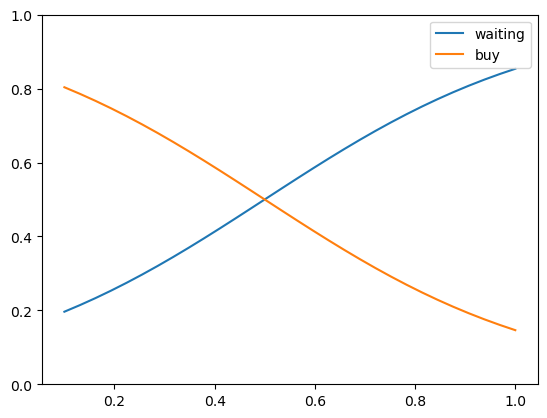

In [42]:
model_test = durable_goods_adoption_model(beta=theta_optimal[0],alpha=theta_optimal[1],
                                          rho=[theta_optimal[2],theta_optimal[3]],
                                          cov=[theta_optimal[4],theta_optimal[5],theta_optimal[5],theta_optimal[6]])
v0 = model_test.solve_vfi()
plt.plot(model_test.grid,v0)
plt.show()
p0 = 1/(np.exp(v0-v0)+np.exp(model_test.beta+model_test.alpha*model_test.grid))
p1 = 1-p0
plt.plot(model_test.grid,p0,label="waiting")
plt.plot(model_test.grid,p1,label="buy")
plt.ylim(0,1)
plt.legend()
plt.show()

In [43]:
prediction_test =  calculate_share(lambda_type1=1,
                    theta_type1=[model_test.beta,model_test.alpha],       
                    rho=model_test.rho,cov=model_test.cov,                    
                    xi=simulate_price_process(T=len(data),model=model_test)[1],
                    data = data)
prediction_test

,sales,sales_type1,sales_decision1_type1,sales_decision0_type1,share,share_type1,share_decision1_type1,share_decision0_type1,lambda1,market_size1
0,17.926259,17.926259,17.926259,982.073741,0.017926,1.0,0.017926,0.982074,1.0,1000.000000
1,21.324502,21.324502,21.324502,960.749239,0.021714,1.0,0.021714,0.978286,1.0,982.073741
2,12.268966,12.268966,12.268966,948.480273,0.012770,1.0,0.012770,0.987230,1.0,960.749239
3,19.537309,19.537309,19.537309,928.942964,0.020599,1.0,0.020599,0.979401,1.0,948.480273
4,15.718817,15.718817,15.718817,913.224147,0.016921,1.0,0.016921,0.983079,1.0,928.942964
...,...,...,...,...,...,...,...,...,...,...
115,3.038770,3.038770,3.038770,135.628963,0.021914,1.0,0.021914,0.978086,1.0,138.667733
116,2.844411,2.844411,2.844411,132.784553,0.020972,1.0,0.020972,0.979028,1.0,135.628963
117,1.835959,1.835959,1.835959,130.948594,0.013827,1.0,0.013827,0.986173,1.0,132.784553
118,2.620063,2.620063,2.620063,128.328531,0.020008,1.0,0.020008,0.979992,1.0,130.948594


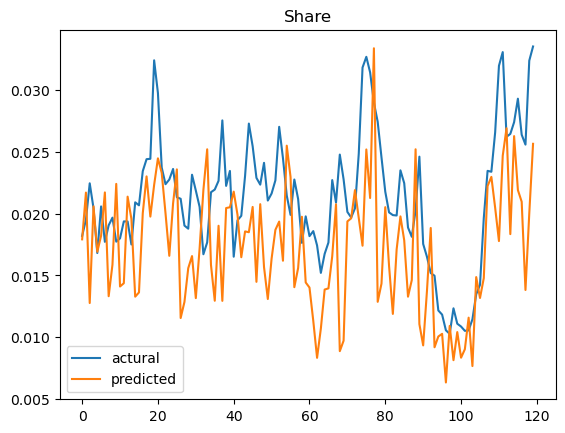

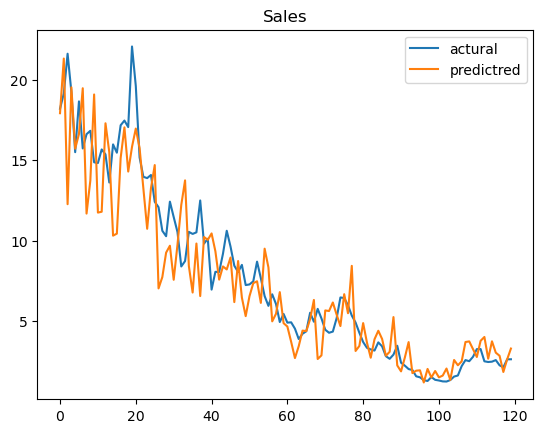

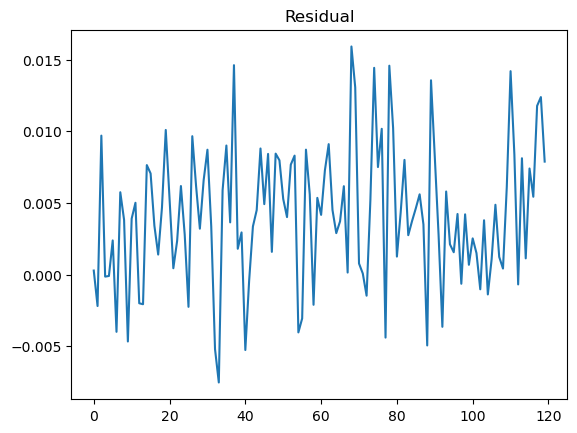

mean of residual:0.004100295899875986


In [45]:
window_size = 3
plt.plot(data.share,label="actural")
plt.plot(prediction_test.share,label="predicted")
#plt.plot(prediction_test.share.rolling(window=window_size).mean(),label="smoothed prediction")
plt.title("Share")
plt.legend()
plt.show()

plt.plot(data.sales,label="actural")
plt.plot(prediction_test.sales,label="predictred")
#plt.plot(prediction_test.sales.rolling(window=window_size).mean(),label="smoothed prediction")
plt.title("Sales")
plt.legend()
plt.show()

plt.plot(data.share-prediction_test.share,label="residual")
plt.title("Residual")
plt.show()
print(f"mean of residual:{np.mean(data.share-prediction_test.share)}")

In [128]:
%%time
# 初期パラメータ
theta_initial = np.ones(7)

bounds = Bounds([ 0, -10, 0, 0, 0, 0, 0], 
                [10,  0,  10, 1, 1, 1,1])

# 分散行列が正定値行列になるための制約条件
def constraint(theta):
    L = np.array([[theta[4], 0], [theta[5], theta[6]]])
    covariance_matrix = np.dot(L, L.T)
    return np.linalg.eigvals(covariance_matrix)

constraints = {'type': 'ineq', 'fun': constraint}


# 最小化問題を解く
result_PartialData = minimize(log_likelihood, theta_initial, args=(data[:11],), method='SLSQP',bounds=bounds,constraints=constraints)

# 最適なパラメータ
theta_PartialData = result_PartialData.x

lambda:1,theta1:[1. 0.],rho:[1. 1.],cov:[[1. 1.]
 [1. 2.]]
xi:11
period length:11
lambda:1,theta1:[1.00000001 0.        ],rho:[1. 1.],cov:[[1. 1.]
 [1. 2.]]
xi:11
period length:11
lambda:1,theta1:[ 1.00000000e+00 -1.49011612e-08],rho:[1. 1.],cov:[[1. 1.]
 [1. 2.]]
xi:11
period length:11
lambda:1,theta1:[1. 0.],rho:[1.00000001 1.        ],cov:[[1. 1.]
 [1. 2.]]
xi:11
period length:11
lambda:1,theta1:[1. 0.],rho:[1.         0.99999999],cov:[[1. 1.]
 [1. 2.]]
xi:11
period length:11
lambda:1,theta1:[1. 0.],rho:[1. 1.],cov:[[0.99999997 0.99999999]
 [0.99999999 2.        ]]
xi:11
period length:11
lambda:1,theta1:[1. 0.],rho:[1. 1.],cov:[[1.         0.99999999]
 [0.99999999 1.99999997]]
xi:11
period length:11
lambda:1,theta1:[1. 0.],rho:[1. 1.],cov:[[1.         1.        ]
 [1.         1.99999997]]
xi:11
period length:11
lambda:1,theta1:[  2.69940567 -10.        ],rho:[1.96145322e-11 1.15942811e-11],cov:[[1.00000000e+00 2.13020712e-11]
 [2.13020712e-11 6.54508478e-01]]
xi:11
period length:11


xi:11
period length:11
lambda:1,theta1:[ 0.36333523 -0.10824798],rho:[0.29909012 0.75729291],cov:[[0.51122451 0.59843335]
 [0.59843335 1.07478893]]
xi:11
period length:11
lambda:1,theta1:[ 0.36333523 -0.108248  ],rho:[0.29909013 0.75729291],cov:[[0.51122451 0.59843335]
 [0.59843335 1.07478893]]
xi:11
period length:11
lambda:1,theta1:[ 0.36333523 -0.108248  ],rho:[0.29909012 0.75729293],cov:[[0.51122451 0.59843335]
 [0.59843335 1.07478893]]
xi:11
period length:11
lambda:1,theta1:[ 0.36333523 -0.108248  ],rho:[0.29909012 0.75729291],cov:[[0.51122453 0.59843337]
 [0.59843337 1.07478893]]
xi:11
period length:11
lambda:1,theta1:[ 0.36333523 -0.108248  ],rho:[0.29909012 0.75729291],cov:[[0.51122451 0.59843336]
 [0.59843336 1.07478895]]
xi:11
period length:11
lambda:1,theta1:[ 0.36333523 -0.108248  ],rho:[0.29909012 0.75729291],cov:[[0.51122451 0.59843335]
 [0.59843335 1.07478895]]
xi:11
period length:11
lambda:1,theta1:[ 0.         -0.17239062],rho:[0.         0.64071453],cov:[[0.00506403 0.

xi:11
period length:11
lambda:1,theta1:[ 0.01982495 -0.30210734],rho:[0.33106658 0.43070384],cov:[[0.01249228 0.07321848]
 [0.07321848 1.0189253 ]]
xi:11
period length:11
lambda:1,theta1:[ 0.01982495 -0.30210734],rho:[0.33106658 0.43070383],cov:[[0.01249229 0.07321849]
 [0.07321849 1.0189253 ]]
xi:11
period length:11
lambda:1,theta1:[ 0.01982495 -0.30210734],rho:[0.33106658 0.43070383],cov:[[0.01249228 0.07321848]
 [0.07321848 1.01892532]]
xi:11
period length:11
lambda:1,theta1:[ 0.01982495 -0.30210734],rho:[0.33106658 0.43070383],cov:[[0.01249228 0.07321848]
 [0.07321848 1.01892532]]
xi:11
period length:11
lambda:1,theta1:[10.  0.],rho:[10.  1.],cov:[[1. 1.]
 [1. 1.]]
xi:11
period length:11
lambda:1,theta1:[ 1.01784246 -0.27189661],rho:[1.29795992 0.48763344],cov:[[0.04023715 0.13832411]
 [0.13832411 0.95324537]]
xi:11
period length:11
lambda:1,theta1:[ 0.11962671 -0.29908627],rho:[0.42775591 0.43639679],cov:[[0.01455671 0.07945332]
 [0.07945332 1.01171943]]
xi:11
period length:11
lam

xi:11
period length:11
lambda:1,theta1:[ 0.02125443 -2.72228958],rho:[0.16023033 0.68710354],cov:[[0.0048383  0.03929501]
 [0.03929501 1.01349648]]
xi:11
period length:11
lambda:1,theta1:[ 0.02125443 -2.7222896 ],rho:[0.16023035 0.68710354],cov:[[0.0048383  0.03929501]
 [0.03929501 1.01349648]]
xi:11
period length:11
lambda:1,theta1:[ 0.02125443 -2.7222896 ],rho:[0.16023033 0.68710356],cov:[[0.0048383  0.03929501]
 [0.03929501 1.01349648]]
xi:11
period length:11
lambda:1,theta1:[ 0.02125443 -2.7222896 ],rho:[0.16023033 0.68710354],cov:[[0.0048383  0.03929502]
 [0.03929502 1.01349648]]
xi:11
period length:11
lambda:1,theta1:[ 0.02125443 -2.7222896 ],rho:[0.16023033 0.68710354],cov:[[0.0048383  0.03929501]
 [0.03929501 1.0134965 ]]
xi:11
period length:11
lambda:1,theta1:[ 0.02125443 -2.7222896 ],rho:[0.16023033 0.68710354],cov:[[0.0048383  0.03929501]
 [0.03929501 1.01349651]]
xi:11
period length:11
lambda:1,theta1:[ 3.37103141e-07 -6.49718506e+00],rho:[2.54491376e-06 9.28608048e-01],cov

xi:11
period length:11
lambda:1,theta1:[ 0.23562448 -5.55075806],rho:[0.13923383 0.73273185],cov:[[0.00156868 0.01014743]
 [0.01014743 0.4996966 ]]
xi:11
period length:11
lambda:1,theta1:[ 0.23562448 -5.55075806],rho:[0.13923383 0.73273183],cov:[[0.00156868 0.01014744]
 [0.01014744 0.4996966 ]]
xi:11
period length:11
lambda:1,theta1:[ 0.23562448 -5.55075806],rho:[0.13923383 0.73273183],cov:[[0.00156868 0.01014743]
 [0.01014743 0.49969661]]
xi:11
period length:11
lambda:1,theta1:[ 0.23562448 -5.55075806],rho:[0.13923383 0.73273183],cov:[[0.00156868 0.01014743]
 [0.01014743 0.49969662]]
xi:11
period length:11
lambda:1,theta1:[ 1.32103687 -8.07034982],rho:[0.18994073 0.69851261],cov:[[0.00122043 0.00213235]
 [0.00213235 0.13187038]]
xi:11
period length:11
lambda:1,theta1:[ 0.6609086  -6.53797948],rho:[0.15910171 0.71932413],cov:[[0.00142703 0.0067897 ]
 [0.0067897  0.32492963]]
xi:11
period length:11
lambda:1,theta1:[ 0.66090862 -6.53797948],rho:[0.15910171 0.71932413],cov:[[0.00142703 0.

xi:11
period length:11
lambda:1,theta1:[ 1.56999671 -6.28565943],rho:[0.12090422 0.75907255],cov:[[0.00198176 0.00792908]
 [0.00792908 0.14464727]]
xi:11
period length:11
lambda:1,theta1:[ 1.56999671 -6.28565943],rho:[0.12090422 0.75907255],cov:[[0.00198176 0.00792908]
 [0.00792908 0.14464728]]
xi:11
period length:11
lambda:1,theta1:[ 0.80319837 -3.35944207],rho:[6.93889390e-15 8.80960331e-01],cov:[[0.00031695 0.00047569]
 [0.00047569 0.04137717]]
xi:11
period length:11
lambda:1,theta1:[ 1.49331687 -5.99303769],rho:[0.1088138  0.77126133],cov:[[0.00175106 0.00681975]
 [0.00681975 0.13063201]]
xi:11
period length:11
lambda:1,theta1:[ 1.49331689 -5.99303769],rho:[0.1088138  0.77126133],cov:[[0.00175106 0.00681975]
 [0.00681975 0.13063201]]
xi:11
period length:11
lambda:1,theta1:[ 1.49331687 -5.99303768],rho:[0.1088138  0.77126133],cov:[[0.00175106 0.00681975]
 [0.00681975 0.13063201]]
xi:11
period length:11
lambda:1,theta1:[ 1.49331687 -5.99303769],rho:[0.10881381 0.77126133],cov:[[0.001

xi:11
period length:11
lambda:1,theta1:[ 0.         -4.00780906],rho:[0.08951888 0.74963858],cov:[[0.00096412 0.0003715 ]
 [0.0003715  0.00326747]]
xi:11
period length:11
lambda:1,theta1:[ 2.06957661e-10 -3.71257776e+00],rho:[0.06408674 0.79657988],cov:[[0.00093042 0.00158647]
 [0.00158647 0.00902637]]
xi:11
period length:11
lambda:1,theta1:[ 1.51081189e-08 -3.71257776e+00],rho:[0.06408674 0.79657988],cov:[[0.00093042 0.00158647]
 [0.00158647 0.00902637]]
xi:11
period length:11
lambda:1,theta1:[ 2.06957661e-10 -3.71257774e+00],rho:[0.06408674 0.79657988],cov:[[0.00093042 0.00158647]
 [0.00158647 0.00902637]]
xi:11
period length:11
lambda:1,theta1:[ 2.06957661e-10 -3.71257776e+00],rho:[0.06408675 0.79657988],cov:[[0.00093042 0.00158647]
 [0.00158647 0.00902637]]
xi:11
period length:11
lambda:1,theta1:[ 2.06957661e-10 -3.71257776e+00],rho:[0.06408674 0.7965799 ],cov:[[0.00093042 0.00158647]
 [0.00158647 0.00902637]]
xi:11
period length:11
lambda:1,theta1:[ 2.06957661e-10 -3.71257776e+00]

xi:11
period length:11
lambda:1,theta1:[ 1.31694357e-08 -3.75948722e+00],rho:[0.07479044 0.77580189],cov:[[0.00205167 0.00296942]
 [0.00296942 0.00986573]]
xi:11
period length:11
lambda:1,theta1:[ 1.31694357e-08 -3.75948722e+00],rho:[0.07479044 0.77580189],cov:[[0.00205167 0.00296942]
 [0.00296942 0.00986573]]
xi:11
period length:11
lambda:1,theta1:[ 0.         -3.25804437],rho:[0.03161577 0.83972516],cov:[[0.00231916 0.0008122 ]
 [0.0008122  0.00233079]]
xi:11
period length:11
lambda:1,theta1:[ 1.18524922e-08 -3.70934294e+00],rho:[0.07047297 0.78219422],cov:[[0.00207768 0.00276624]
 [0.00276624 0.00882116]]
xi:11
period length:11
lambda:1,theta1:[ 2.67536534e-08 -3.70934294e+00],rho:[0.07047297 0.78219422],cov:[[0.00207768 0.00276624]
 [0.00276624 0.00882116]]
xi:11
period length:11
lambda:1,theta1:[ 1.18524922e-08 -3.70934292e+00],rho:[0.07047297 0.78219422],cov:[[0.00207768 0.00276624]
 [0.00276624 0.00882116]]
xi:11
period length:11
lambda:1,theta1:[ 1.18524922e-08 -3.70934294e+00]

xi:11
period length:11
lambda:1,theta1:[ 1.94947637e-09 -3.29748230e+00],rho:[0.04352768 0.83648339],cov:[[3.74822929e-03 1.20132770e-12]
 [1.20132770e-12 2.70477150e-03]]
xi:11
period length:11
lambda:1,theta1:[ 3.12753495e-09 -3.30461450e+00],rho:[0.04185807 0.8442983 ],cov:[[3.65666074e-03 1.94423764e-12]
 [1.94423764e-12 2.56845989e-03]]
xi:11
period length:11
lambda:1,theta1:[ 1.80286961e-08 -3.30461450e+00],rho:[0.04185807 0.8442983 ],cov:[[3.65666074e-03 1.94423764e-12]
 [1.94423764e-12 2.56845989e-03]]
xi:11
period length:11
lambda:1,theta1:[ 3.12753495e-09 -3.30461449e+00],rho:[0.04185807 0.8442983 ],cov:[[3.65666074e-03 1.94423764e-12]
 [1.94423764e-12 2.56845989e-03]]
xi:11
period length:11
lambda:1,theta1:[ 3.12753495e-09 -3.30461450e+00],rho:[0.04185808 0.8442983 ],cov:[[3.65666074e-03 1.94423764e-12]
 [1.94423764e-12 2.56845989e-03]]
xi:11
period length:11
lambda:1,theta1:[ 3.12753495e-09 -3.30461450e+00],rho:[0.04185807 0.84429832],cov:[[3.65666074e-03 1.94423764e-12]
 [

xi:11
period length:11
lambda:1,theta1:[ 0.1055258  -3.40889774],rho:[0.02207354 0.9055588 ],cov:[[0.00185723 0.00035304]
 [0.00035304 0.00231322]]
xi:11
period length:11
lambda:1,theta1:[ 0.         -3.50307016],rho:[0.01812471 0.92718243],cov:[[0.000251  0.       ]
 [0.        0.0019013]]
xi:11
period length:11
lambda:1,theta1:[ 0.09497322 -3.41831498],rho:[0.02167866 0.90772116],cov:[[0.00162976 0.00029764]
 [0.00029764 0.00226469]]
xi:11
period length:11
lambda:1,theta1:[ 0.09497323 -3.41831498],rho:[0.02167866 0.90772116],cov:[[0.00162976 0.00029764]
 [0.00029764 0.00226469]]
xi:11
period length:11
lambda:1,theta1:[ 0.09497322 -3.41831496],rho:[0.02167866 0.90772116],cov:[[0.00162976 0.00029764]
 [0.00029764 0.00226469]]
xi:11
period length:11
lambda:1,theta1:[ 0.09497322 -3.41831498],rho:[0.02167867 0.90772116],cov:[[0.00162976 0.00029764]
 [0.00029764 0.00226469]]
xi:11
period length:11
lambda:1,theta1:[ 0.09497322 -3.41831498],rho:[0.02167866 0.90772118],cov:[[0.00162976 0.0002

xi:11
period length:11
lambda:1,theta1:[ 0.17994783 -3.49333737],rho:[0.01970057 0.91342981],cov:[[1.26192666e-03 4.74720437e-17]
 [4.74720437e-17 2.15331404e-03]]
xi:11
period length:11
lambda:1,theta1:[ 0.17994783 -3.49333739],rho:[0.01970058 0.91342981],cov:[[1.26192666e-03 4.74720437e-17]
 [4.74720437e-17 2.15331404e-03]]
xi:11
period length:11
lambda:1,theta1:[ 0.17994783 -3.49333739],rho:[0.01970057 0.91342982],cov:[[1.26192666e-03 4.74720437e-17]
 [4.74720437e-17 2.15331404e-03]]
xi:11
period length:11
lambda:1,theta1:[ 0.17994783 -3.49333739],rho:[0.01970057 0.91342981],cov:[[1.26192772e-03 4.74720636e-17]
 [4.74720636e-17 2.15331404e-03]]
xi:11
period length:11
lambda:1,theta1:[ 0.17994783 -3.49333739],rho:[0.01970057 0.91342981],cov:[[1.26192666e-03 5.29343023e-10]
 [5.29343023e-10 2.15331404e-03]]
xi:11
period length:11
lambda:1,theta1:[ 0.17994783 -3.49333739],rho:[0.01970057 0.91342981],cov:[[1.26192666e-03 4.74720437e-17]
 [4.74720437e-17 2.15331543e-03]]
xi:11
period len

xi:11
period length:11
lambda:1,theta1:[ 0.         -3.47655563],rho:[0.02252971 0.91179403],cov:[[1.24371815e-03 3.02383731e-17]
 [3.02383731e-17 2.13480866e-03]]
xi:11
period length:11
lambda:1,theta1:[ 0.         -3.47655563],rho:[0.02252971 0.91179403],cov:[[1.24371710e-03 5.25509925e-10]
 [5.25509925e-10 2.13480866e-03]]
xi:11
period length:11
lambda:1,theta1:[ 0.         -3.47655563],rho:[0.02252971 0.91179403],cov:[[1.24371710e-03 3.02383603e-17]
 [3.02383603e-17 2.13481004e-03]]
xi:11
period length:11
lambda:1,theta1:[ 0.         -3.47193753],rho:[0.02280709 0.91060075],cov:[[1.25528273e-03 1.99114247e-17]
 [1.99114247e-17 2.14298096e-03]]
xi:11
period length:11
lambda:1,theta1:[ 1.49011612e-08 -3.47193753e+00],rho:[0.02280709 0.91060075],cov:[[1.25528273e-03 1.99114247e-17]
 [1.99114247e-17 2.14298096e-03]]
xi:11
period length:11
lambda:1,theta1:[ 0.         -3.47193751],rho:[0.02280709 0.91060075],cov:[[1.25528273e-03 1.99114247e-17]
 [1.99114247e-17 2.14298096e-03]]
xi:11
pe

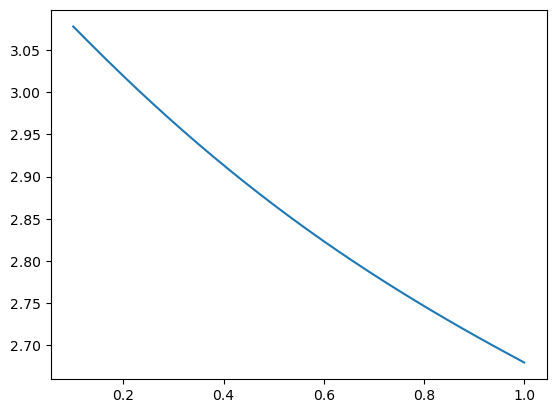

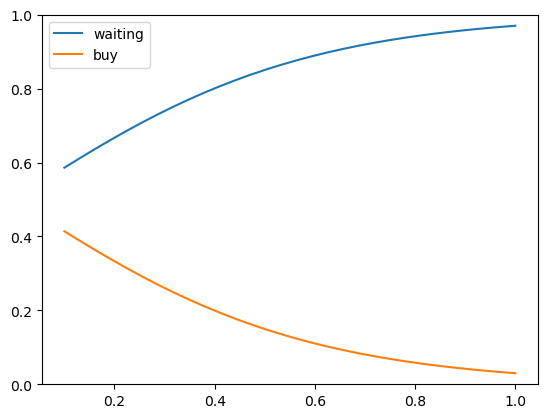

In [131]:
model_test = durable_goods_adoption_model(beta=theta_PartialData[0],alpha=theta_PartialData[1],
                                          rho=[theta_PartialData[2],theta_PartialData[3]],
                                          cov=[theta_PartialData[4],theta_PartialData[5],theta_PartialData[5],theta_PartialData[6]])
v0 = model_test.solve_vfi()
plt.plot(model_test.grid,v0)
plt.show()
p0 = 1/(np.exp(v0-v0)+np.exp(model_test.beta+model_test.alpha*model_test.grid))
p1 = 1-p0
plt.plot(model_test.grid,p0,label="waiting")
plt.plot(model_test.grid,p1,label="buy")
plt.ylim(0,1)
plt.legend()
plt.show()

In [134]:
prediction_test =  calculate_share(lambda_type1=1,
                    theta_type1=[model_test.beta,model_test.alpha],       
                    rho=model_test.rho,cov=model_test.cov,                    
                    xi=simulate_price_process(T=len(data),model=model_test)[1],
                    data = data)
prediction_test

,sales,sales_type1,sales_decision1_type1,sales_decision0_type1,share,share_type1,share_decision1_type1,share_decision0_type1,lambda1,market_size1
0,4.379679,4.379679,4.379679,995.620321,0.004380,1.0,0.004380,0.995620,1.0,1000.0
1,6.760392,6.760392,6.760392,988.239608,0.006794,1.0,0.006794,0.993206,1.0,995.0
2,4.805696,4.805696,4.805696,983.194304,0.004864,1.0,0.004864,0.995136,1.0,988.0
3,7.616067,7.616067,7.616067,976.383933,0.007740,1.0,0.007740,0.992260,1.0,984.0
4,5.605706,5.605706,5.605706,970.394294,0.005744,1.0,0.005744,0.994256,1.0,976.0
...,...,...,...,...,...,...,...,...,...,...
115,0.896590,0.896590,0.896590,13.103410,0.064042,1.0,0.064042,0.935958,1.0,14.0
116,0.713917,0.713917,0.713917,12.286083,0.054917,1.0,0.054917,0.945083,1.0,13.0
117,0.475439,0.475439,0.475439,11.524561,0.039620,1.0,0.039620,0.960380,1.0,12.0
118,0.909654,0.909654,0.909654,11.090346,0.075804,1.0,0.075804,0.924196,1.0,12.0


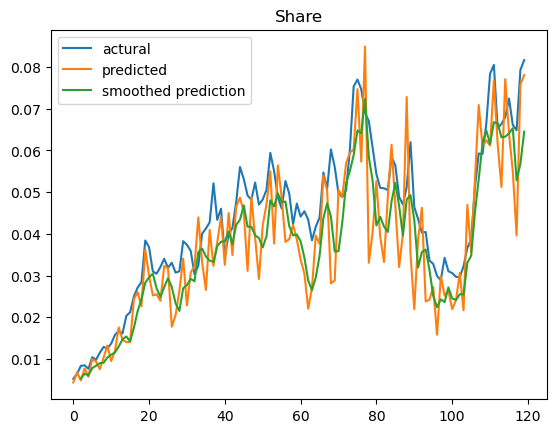

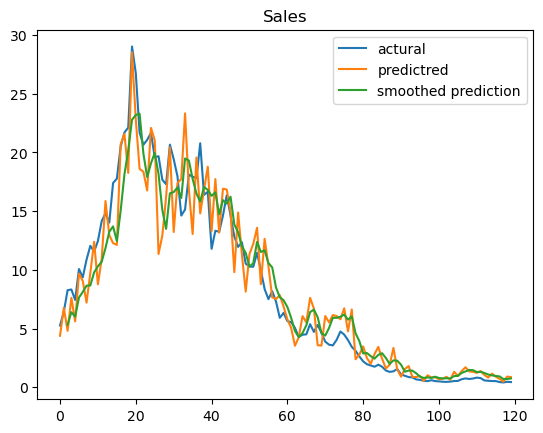

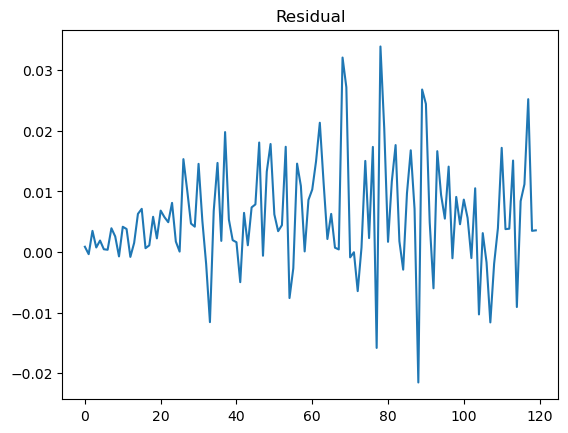

mean of residual:0.005996588113411428


In [133]:
window_size = 3
plt.plot(data.share,label="actural")
plt.plot(prediction_test.share,label="predicted")
plt.plot(prediction_test.share.rolling(window=window_size).mean(),label="smoothed prediction")
plt.title("Share")
plt.legend()
plt.show()

plt.plot(data.sales,label="actural")
plt.plot(prediction_test.sales,label="predictred")
plt.plot(prediction_test.sales.rolling(window=window_size).mean(),label="smoothed prediction")
plt.title("Sales")
plt.legend()
plt.show()

plt.plot(data.share-prediction_test.share,label="residual")
plt.title("Residual")
plt.show()
print(f"mean of residual:{np.mean(data.share-prediction_test.share)}")